Pareto front size: 148


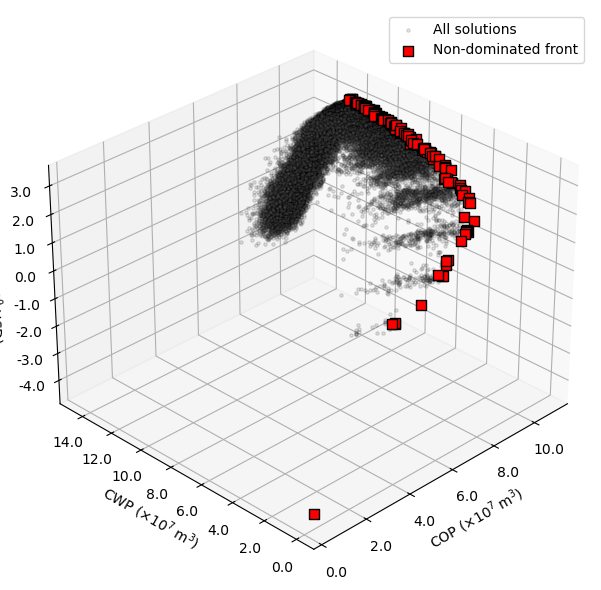

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------------------------------------------------
# Load dataset
# ---------------------------------------------------
df = pd.read_csv("datasets/MOU2D.csv", delimiter=";", engine="python")

# Use first THREE objectives
objs = df.values[:, :3].astype(float)

# ---------------------------------------------------
# Objective directions
# True  -> minimize
# False -> maximize
# ---------------------------------------------------
minimize = np.array([False, True, False])

# ---------------------------------------------------
# Dominance check (mixed objectives)
# ---------------------------------------------------
def dominates(q, p, minimize):
    better_or_equal = True
    strictly_better = False

    for k in range(len(p)):
        if minimize[k]:
            if q[k] > p[k]:
                better_or_equal = False
                break
            if q[k] < p[k]:
                strictly_better = True
        else:
            if q[k] < p[k]:
                better_or_equal = False
                break
            if q[k] > p[k]:
                strictly_better = True

    return better_or_equal and strictly_better

# ---------------------------------------------------
# Update Pareto front with a batch
# ---------------------------------------------------
def update_pareto_front(current_pf, batch, minimize):
    current_pf = list(current_pf)

    for b in batch:
        dominated = False
        to_remove = []

        for i, p in enumerate(current_pf):
            if dominates(p, b, minimize):
                dominated = True
                break
            if dominates(b, p, minimize):
                to_remove.append(i)

        if not dominated:
            for idx in reversed(to_remove):
                current_pf.pop(idx)
            current_pf.append(b)

    return current_pf

# ---------------------------------------------------
# Batch-wise Pareto computation
# ---------------------------------------------------
batch_size = 2000
pareto_frontier = []

for start in range(0, len(objs), batch_size):
    batch = objs[start:start + batch_size]
    pareto_frontier = update_pareto_front(pareto_frontier, batch, minimize)

pf = np.array(pareto_frontier)

print(f"Pareto front size: {len(pf)}")

# ---------------------------------------------------
# Plot (3D)
# ---------------------------------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# All solutions
ax.scatter(
    objs[:, 0], objs[:, 1], objs[:, 2],
    color="grey", alpha=0.15, s=5,
    rasterized=True,
    edgecolors="black",
    zorder=1,
    depthshade=False,
    label="All solutions"
)

# Pareto front (ON TOP)
ax.scatter(
    pf[:, 0], pf[:, 1], pf[:, 2],
    color="red", s=60, marker="s",
    edgecolors="black",
    zorder=100,
    depthshade=False,
    label="Non-dominated front"
)

# Axis labels
ax.set_xlabel("COP ($\\times 10^7 \\; \\mathrm{m}^3$)")
ax.set_ylabel("CWP ($\\times 10^7 \\; \\mathrm{m}^3$)")
ax.set_zlabel("NPV ($\\times 10^9 \\; \\mathrm{USD}$)")

# Axis formatting
formatter = FuncFormatter(lambda x, _: f"{x/1e7:.1f}")
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(lambda x, _: f"{x/1e9:.1f}")
ax.zaxis.set_major_formatter(formatter)


ax.legend()
plt.tight_layout()
ax.view_init(elev=30, azim=225)
plt.savefig("figures/MOU2D.pdf", dpi=300)
plt.show()


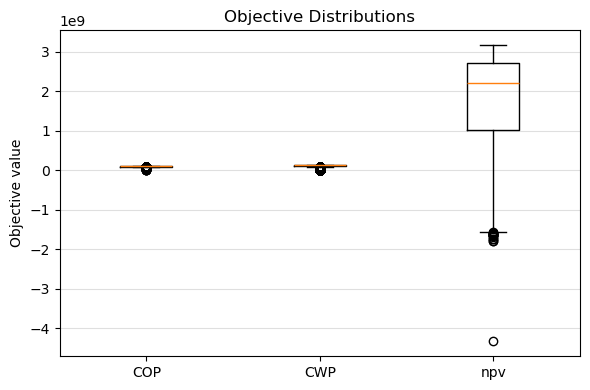

In [5]:
import matplotlib.pyplot as plt

obj_cols = ["COP", "CWP", "NPV"]

plt.figure(figsize=(6, 4))
plt.boxplot(
    objs,
    tick_labels=obj_cols,
    showfliers=True
)

plt.ylabel("Objective value")
plt.title("Objective Distributions")
plt.grid(True, axis="y", alpha=0.4)
plt.tight_layout()
plt.show()